### External Sources and packages
Below cell lists the external dependencies of this notebook. I have utilized current well known third party libraries made for NLP tasks such as: 
1. nltk https://www.nltk.org/
2. gensim https://radimrehurek.com/gensim/index.html

I have kept the usage of external librairies varied to keep the tasks simplistic and easy to explain and to demonstrate my understanding and usage of the same.
For generating graphs and charts:
3. matplotlib https://matplotlib.org

In [2]:
import base64
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

from pprint import pprint
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import re

import gensim
import os
import time
from gensim.models.word2vec import LineSentence
from gensim.models.fasttext import FastText as FT_gensim
from pyemd import emd

print "all imports worked nicely"

[nltk_data] Downloading package stopwords to /home/dupree/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/dupree/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


all imports worked nicely


### Data Exploration
1. Parsing the file into a Pandas dataframe
2. Checking some of the values for individual columns - description, level and title
3. Getting all the possible values of column "level" 

In [3]:
# pd.set_option('display.max_colwidth', 100)
df = pd.read_json("data.json", orient='columns')
df.head(5)

,description,level,title
0,OUTFITTERY is Europe’s biggest Personal Shoppi...,Entry Level,Frontend Engineer (m/f)
1,OUTFITTERY is Europe’s biggest Personal Shoppi...,Senior Level,Senior Product Manager (m/f)
2,JOB DESCRIPTION\nPamet is looking for Android ...,Entry Level,Android Developer
3,We are looking for a Development Lead with 5+ ...,Senior Level,Development Lead
4,JOB DESCRIPTION\nPamet is looking for a IBM We...,Entry Level,IBM WebSphere Portal Developer


In [4]:
# quick statistical summary of the input data
df.describe()

,description,level,title
count,216,141,216
unique,213,4,212
top,no,Senior Level,Web Developer
freq,2,57,2


In [5]:
# getting possible values for "level" column
df.level.unique()

array([u'Entry Level', u'Senior Level', u'Mid Level', u'Internship', nan],
      dtype=object)

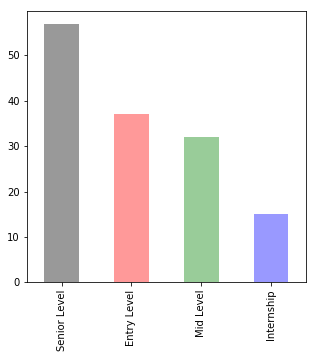

In [6]:
# showing the distribution of available data w.r.t seniority level  
counts = df["level"].value_counts()
plot_data_level = df[df["level"].isin(counts[counts >= 2].index)]
plot_data_level["level"].value_counts().plot.bar(y="level", figsize=(5,5),alpha = 0.4, color=['black', 'red', 'green', 'blue', 'cyan'])


In [49]:
pd.set_option('display.max_colwidth', 200)
# checking the missing "level" data in last entries
df.tail(5)

,description,level,title
211,"Work in a one of a kind international environment; allow your contributions to be displayed publicly on our website and our social media networks, in which without a doubt, you will enjoy each par...",NaN,Native Italian Translation Internship
212,Work in a unique international environment and enjoy an internship where your contribution is displayed publicly on our website and our social media network.\n New York Habitat is looking for nati...,NaN,International Translation Internship Program (Native Spanish Students)
213,"Photography - New York Habitat Internship\nWho We Are: New York Habitat (http://www.nyhabitat.com) is an international real estate agency specialized in the furnished rental markets of New York, ...",NaN,Photography - New York Habitat Internship
214,"Are you free every day from 10:30am - 1:30pm and own a reliable vehicle? You could make up to $60 delivering downtown Toronto in one of the fastest growing startups, Foodee. Perfect for students...",NaN,High Paying Part Time Delivery Driver
215,OUTFITTERY is Europe’s biggest Personal Shopping Service and we have a clear mission: We build the future of menswear shopping. Our goal is to make men happy!\nYou want to have a lot of freedom an...,NaN,Agile Coach (m/f)


### Observation(s) from initial data exploration
1. **level** contains values - 'Entry Level', 'Senior Level', 'Mid Level' and 'Internship'
2. Empty (NaN) values need to be inferred
3. **level** values are labelled for first 141 entries and last 74 entries need to be inferred.
<br>**NOTE:** It can be seen sometimes the labelled "level" values might NOT be reliable as well. For example the entry below labels a **3+ years experience** job description as an **Entry Level** position. 

In [44]:
# example of a "possible" mislabelled job description
pd.set_option('display.max_colwidth', -1)
df.head(1)

,description,level,title
0,"OUTFITTERY is Europe’s biggest Personal Shopping Service and we have a clear mission: We build the future of menswear shopping. Our goal is to make men happy!\nAre you interested in building products used by hundreds of thousend of people? Do you like delivering code at a rapid pace? Outfittery is seeking an experienced Frontend Engineer (m/f) that is passionate about building mobile and desktop web applications. This position is full-time and is based in our Berlin office.\n \nYour responsibilities:\n\n\nImplement the features and user interfaces of Outfittery products like the Outfit Recommender\n\n\nArchitect efficient and reusable front-end systems that drive complex web applications\n\n\nCollaborate with Product Designers, Product Managers, and Software Engineers to deliver compelling user-facing products\n\n\nIdentify and resolve performance and scalability issues\n\n\n \nYour profile:\n\n\n3+ years of JavaScript experience, including concepts like asynchronous programming, closures, types, and ES6. Experience with Angular/ExtJs/React is a plus\n\n\n3+ years of HTML/CSS experience, including concepts like layout, specificity, cross browser compatibility, and accessibility\n\n\n3+ years experience with browser APIs and optimizing front end performance\n\n\nBS/MS in Computer Science or a related technical field is a plus\n\nEffective oral and written English communication skills\nYou're ready to live in Berlin, Germany\n\n \nWe offer:\n\nAn exciting workplace in a motivated team with low hierarchies\nA dynamic company with short and efficient decision making processes\nAir, love, life and work in the Berlin Startup-Scene\n\n \nIntrigued? Then send us your application with your salary expectations and possible starting date. Your contact person is Iris Hay.",Entry Level,Frontend Engineer (m/f)


### Choice of approach and algorithm
1. Missing level information can be inferred from two available data fields - **title** and **description** respectively.
2. **Inferring using Title**:
    -  Since the data/keywords in title field is limited to 4-5 keywords, this approach seems fairly starightforward and compuationally less expensive.
    -  If the title itself contains keywords such as - Internship, Entry(Jr.), Senior(Sr.) then return these specific keywords as the seniority level.  
    -  If not, **title** of the incomplete offer information can be matched with rest of available job titles and the seniority level of the closest matching title can be inferred as the seniority level of the incomplete offer information.
    -  a variety of **text similarity algorithms** can be utilized for this task such as: term frequency based method **tf/idf** and word vectors based methods such as **smooth inverse frequency, word movers distance (WMD)**.

<br>

3. **Inferring using Description**:  This task grows in complexity since the job description (may) contain a lot of additional data regarding the company and work profile. In this case task can be broken down into further substeps:
    -  extract job description as a list of sentences.
    -  if the job description contains keyword "intern", "internship" then assign it as Internship level. 
    -  find out the **sentence that contains keywords of interest: "years", "experience".** 
    -  extract the numeric value in this sentence(**POS** might help here) and based on this number assign a category to the seniority level. For eg. Entry level: 0-2 years, Mid level: 3-5 years and Senior level: 5+ years
    
**NOTE**: I do NOT think, finding similarity among different **offer descriptions**(using tf/idf or word/sentence embedding methods) and then assigning the seniority level of closest matching offer description to the missing offfer value will lead to favourable results. Since there will be high similarity among jobs posted by same organisation with different seniority levels.  



In [7]:
# extracting columnwise data into list objects
job_desc = df["description"].tolist()
job_level = df["level"].tolist()
job_title = df["title"].tolist()

print len(job_desc), len(job_level), len(job_title)
print job_level[:5]
print job_title[:5]

print job_level[-5:]
print job_title[-5:]


216 216 216
[u'Entry Level', u'Senior Level', u'Entry Level', u'Senior Level', u'Entry Level']
[u'Frontend Engineer (m/f)', u'Senior Product Manager (m/f)', u'Android Developer', u'Development Lead', u'IBM WebSphere Portal Developer']
[nan, nan, nan, nan, nan]
[u'Native Italian Translation Internship', u'International Translation Internship Program (Native Spanish Students)', u'Photography - New York Habitat Internship', u'High Paying Part Time Delivery Driver', u'Agile Coach (m/f)']


In [23]:
# data specific stop words
additional_stop_words = ["30/hr","m/f", "f/m"]
stop_words.extend(additional_stop_words)

# a custom tokenize function to take care of single sentence as well as multiple sentence inputs
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
#     tokens = nltk.word_tokenize(text)    
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation) 
    # and words whose length is less than 2 characters - removes 's, $ '  tokens from data 
    for token in tokens:
        if re.search('[a-zA-Z]', token) and len(token) > 2:
            filtered_tokens.append(token)
    return filtered_tokens
    
# initializing a tfIDF vectorizer for job_title corpus    
tfidf_vectorizer = TfidfVectorizer(max_df=0.7 , max_features=2000,
                                 min_df=2 , stop_words= stop_words,
                                 use_idf=False, tokenizer=tokenize_only)

%time tfidf_matrix = tfidf_vectorizer.fit_transform(job_title) #fit the vectorizer to synopses

print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()

from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
dist = 1 - cosine_similarity(tfidf_matrix)

# TFIDF features on the entire corpus
print terms
print len(terms)

CPU times: user 108 ms, sys: 28 ms, total: 136 ms
Wall time: 343 ms
(216, 121)
[u'account', u'acquisition', u'agile', u'analyst', u'android', u'application', u'associate', u'automation', u'backend', u'based', u'berlin', u'brand', u'business', u'community', u'consultant', u'content', u'corporate', u'country', u'course', u'coursera', u'customer', u'data', u'delivery', u'denmark', u'designer', u'desk', u'developer', u'development', u'devops', u'digital', u'director', u'driver', u'end', u'engineer', u'engineering', u'enterprise', u'executive', u'experience', u'finance', u'financial', u'food', u'french', u'front', u'frontend', u'full', u'full-stack', u'general', u'german', u'growth', u'head', u'help', u'highest', u'india', u'indonesia', u'infrastructure', u'integrated', u'intern', u'international', u'internship', u'ios', u'java', u'job', u'junior', u'lead', u'london', u'management', u'manager', u'manual', u'marketing', u'media', u'men', u'mobile', u'native', u'netherlands', u'new', u'onboar

In [9]:
# calculating distance matrix using word embeddings
# using 300dim word vectors trained on wikipedia dataset and loading them in Gensim word vectors model
%time model = gensim.models.KeyedVectors.load_word2vec_format("/home/dupree/Downloads/wiki-news-300d-1M-subword.vec", binary=False)

print "Size of vocabulary in model is %d" % len(model.vocab)
model_wordList = model.index2word
print type(model_wordList), len(model_wordList)
print "first 20 words in the model vocabulary are: ", model_wordList[:20]
 

CPU times: user 6min, sys: 3.81 s, total: 6min 3s
Wall time: 6min 32s
Size of vocabulary in model is 999994
<type 'list'> 999994
first 20 words in the model vocabulary are:  [u',', u'the', u'.', u'and', u'of', u'to', u'in', u'a', u'"', u':', u')', u'that', u'(', u'is', u'for', u'on', u'*', u'with', u'as', u'it']


In [12]:
from time import time
# Applying Word Movers Distance and analysing results on the current corpus
# http://proceedings.mlr.press/v37/kusnerb15.pdf

# Initialize WmdSimilarity.
from gensim.similarities import WmdSimilarity
instance = WmdSimilarity(job_title, model, num_best=10)
start = time()

sims = instance[job_title[200]]  # A query is simply a "look-up" in the similarity class.
print 'Cell took %.2f seconds to run.' %(time() - start)

Cell took 1.26 seconds to run.


In [13]:
# pre-processing job_title entries inorder to remove tokens such as: in, m/f, f/m, $.  
#tokenize
%time tokenized_title = [tokenize_only(text) for text in job_title]
    
#remove stop words
%time job_title_processed = [[word for word in text if word not in stop_words] for text in tokenized_title]

for word in job_title_processed[2]:
    print word,

CPU times: user 77.4 ms, sys: 7.97 ms, total: 85.4 ms
Wall time: 77.2 ms
CPU times: user 5.18 ms, sys: 15 µs, total: 5.19 ms
Wall time: 4.99 ms
Android Developer


In [14]:
# computing pairwise distance matrix for the given corpus using WMD
distance_WMD = np.zeros((len(job_title),len(job_title)))
%timeit
print len(job_title)
print distance_WMD.shape
# calculate distances only between different documents(i!=j) and where the distance is not yet set
# (all are zero intialised)
# compute only the upper diagonal elements: once calculated dist(i, j), 
# set dist(j, i) to be the same value to save extra computations  
start = time()
for i in range(len(job_title)):
    for j in range(len(job_title)):
        if distance_WMD[i,j] == 0 and i != j:
            distance_WMD[i,j] = model.wmdistance(job_title_processed[i], job_title_processed[j])
            distance_WMD[j,i] = distance_WMD[i,j]
print 'Cell took %.2f seconds to run.' %(time() - start)

216
(216, 216)
Cell took 11.79 seconds to run.


In [15]:
# function that takes (N*N) distance matrix for job titles and returns the closest matching job title whose 
# seniority level information is available

def find_similar_title(dist, job_id):
    sorted_distances = dist[job_id].argsort() # sorting the distances
#     print "For job_title %s, top 5 most similar job titles are:" %job_title[job_id]
    similar_titles = []
    for i in range(1, 8): # ignore element at zero index as it's the job_id itself.
        similar_titles.append(job_title[sorted_distances[i]])
#     print similar_titles
    for i in range(1, len(sorted_distances)): # iterate over similar titles and return the one whose seniority level is known (id < 140)
        if sorted_distances[i] < 140:
#             print "matched with job_title: %s" % job_title[sorted_distances[i]]
            return sorted_distances[i]
    return None 
    

# sanity check
find_similar_title(dist, 200)
print job_level[find_similar_title(dist, 200)]

Senior Level


In [43]:
# array([u'Entry Level', u'Senior Level', u'Mid Level', u'Internship', nan],
#       dtype=object

# check for specific keywords in the job title
def jobLevel_using_keywords(job_id):
    keywords_senior = ["Sr.", "Senior", "Lead", "Head"]
    keywords_junior = ["Jr.", "Junior"]
    keywords_intern = ["Intern", "Internship"]
    job_titleString = job_title[job_id].title() #inorder to match the case information in respective keywords
    if any(keyword in job_titleString for keyword in keywords_senior):
        return u'Senior Level'
    if any(keyword in job_titleString for keyword in keywords_junior):
        return u'Entry Level'
    if any(keyword in job_titleString for keyword in keywords_intern):
        return u'Internship'
    return None
    
# function to generate missing data
def generate_job_level(job_id, distance_matrix):
    jobLevel = jobLevel_using_keywords(job_id) # check for specific keywords
    if (jobLevel != None):
        return jobLevel
    else:
        similar_job_id = find_similar_title(distance_matrix, job_id) # find_similar_title() returns the id of most similar job title
        return job_level[similar_job_id]

In [78]:
pd.set_option('display.max_colwidth', 150)

# generating the augmented data using term frequency based tfIDF(similarity) distance matrix :
df_tfIDF = df
for i in range(141, 216):
    df_tfIDF["level"][i] =  generate_job_level(i, dist)

# exporting the dataframe to json
out = df_tfIDF.to_json(orient='records')
# writing it to a file
with open('tfIDF.json', 'w') as f: 
    f.write(out)

df_tfIDF.tail(74)

,description,level,title
142,OUTFITTERY is Europe’s biggest Personal Shopping Service and we have a clear mission: We build the future of menswear shopping. Our goal is to mak...,Senior Level,DevOps Engineer (m/f)
143,OUTFITTERY is Europe’s biggest Personal Shopping Service and we have a clear mission: Take the pain out of shopping for men! This we achieve by of...,Senior Level,Head of Product Management (IT) (m/f)
144,OUTFITTERY is Europe’s biggest Personal Shopping Service and we have a clear mission: We build the future of menswear shopping. Our goal is to mak...,Mid Level,Help Desk Support (m/f)
145,OUTFITTERY is Europe’s biggest Personal Shopping Service and we have a clear mission: We build the future of menswear shopping. Our goal is to mak...,Internship,Intern Help Desk (m/f)
146,no,Entry Level,Praktikant im Bereich Operations & Customer Service
147,OUTFITTERY is Europe’s biggest Personal Shopping Service and we have a clear mission: We build the future of menswear shopping. Our goal is to mak...,Entry Level,Sales Consultant Belgium in Berlin (m/f)
148,OUTFITTERY is Europe’s biggest Personal Shopping Service and we have a clear mission: We build the future of menswear shopping. Our goal is to mak...,Entry Level,Sales Consultant Denmark in Berlin (m/f)
149,OUTFITTERY is Europa's grootste personal shopping service en we hebben een duidelijke missie: ‘Mannen verlossen van het shoppen.’ Wil je veel vrij...,Entry Level,Sales Consultant in Berlin (m/v)
150,OUTFITTERY is Europe’s biggest Personal Shopping Service and we have a clear mission: We build the future of menswear shopping. Our goal is to mak...,Entry Level,Sales Consultant Netherlands (m/f)
151,OUTFITTERY is Europe’s biggest Personal Shopping Service and we have a clear mission: We build the future of menswear shopping. Our goal is to mak...,Entry Level,Sales Consultant Sweden in Berlin (m/f)


In [77]:
# generating the augmented data using word embeddings based Word Movers Distance(similarity) matrix :
df_wmd = df
for i in range(141, 216):
    df_wmd["level"][i] =  generate_job_level(i, distance_WMD)

# exporting the dataframe to json
out = df_wmd.to_json(orient='records')
# writing it to a file
with open('wmd_data.json', 'w') as f: 
    f.write(out)

df_wmd.tail(74)

,description,level,title
142,OUTFITTERY is Europe’s biggest Personal Shopping Service and we have a clear mission: We build the future of menswear shopping. Our goal is to mak...,Mid Level,DevOps Engineer (m/f)
143,OUTFITTERY is Europe’s biggest Personal Shopping Service and we have a clear mission: Take the pain out of shopping for men! This we achieve by of...,Senior Level,Head of Product Management (IT) (m/f)
144,OUTFITTERY is Europe’s biggest Personal Shopping Service and we have a clear mission: We build the future of menswear shopping. Our goal is to mak...,Mid Level,Help Desk Support (m/f)
145,OUTFITTERY is Europe’s biggest Personal Shopping Service and we have a clear mission: We build the future of menswear shopping. Our goal is to mak...,Internship,Intern Help Desk (m/f)
146,no,Entry Level,Praktikant im Bereich Operations & Customer Service
147,OUTFITTERY is Europe’s biggest Personal Shopping Service and we have a clear mission: We build the future of menswear shopping. Our goal is to mak...,Senior Level,Sales Consultant Belgium in Berlin (m/f)
148,OUTFITTERY is Europe’s biggest Personal Shopping Service and we have a clear mission: We build the future of menswear shopping. Our goal is to mak...,Internship,Sales Consultant Denmark in Berlin (m/f)
149,OUTFITTERY is Europa's grootste personal shopping service en we hebben een duidelijke missie: ‘Mannen verlossen van het shoppen.’ Wil je veel vrij...,Senior Level,Sales Consultant in Berlin (m/v)
150,OUTFITTERY is Europe’s biggest Personal Shopping Service and we have a clear mission: We build the future of menswear shopping. Our goal is to mak...,Senior Level,Sales Consultant Netherlands (m/f)
151,OUTFITTERY is Europe’s biggest Personal Shopping Service and we have a clear mission: We build the future of menswear shopping. Our goal is to mak...,Senior Level,Sales Consultant Sweden in Berlin (m/f)


### Estimate quality of the result:
1. In my opinion majority of results(haven't cross validated with job descriptions and done the exact math yet) are **assigned to acceptable seniority level**.
2. I expect **term frequency** based methods to **outperform word embeddings** based method for this use case.

### Second Method:
3. **Inferring using Description**:  This task grows in complexity since the job description (may) contain a lot of additional data regarding the company and work profile. In this case task can be broken down into further substeps:
    -  extract job description as a list of sentences.
    -  if the job description contains keyword "intern", "internship" then assign it as Internship level. 
    -  find out the **sentence that contains keywords of interest: "years", "experience".** 
    -  extract the numeric value in this sentence(**POS** might help here) and based on this number assign a category to the seniority level. For eg. Entry level: 0-2 years, Mid level: 3-5 years and Senior level: 5+ years
    
**NOTE**: I do NOT think, finding similarity among different **offer descriptions**(using tf/idf or word/sentence embedding methods) and then assigning the seniority level of closest matching offer description to the missing offfer value will lead to favourable results. Since there will be high similarity among jobs posted by same organisation with different seniority levels.  

Due to the time constraints, I am not able to cover this.
<br> It was a nice task, that seems quiet straightforward from outside but then I learnt a few complexities and problems that arise. **I enjoyed working on it**.  

### Evaluation:
1. Taking the job_level information of first 140 records as the ground truth.
2. Evaluate the model performance for both the above methods against this ground truth data.
3. Calculate and Genrate performance metrics. 

In [57]:
gt_data = job_level[:140]
len(gt_data)

tfIDF_predicted_data = [ generate_job_level(i, dist) for i in range(0,140)]
wmd_predicted_data = [ generate_job_level(i, distance_WMD) for i in range(0,140)]

In [53]:
y_actu = pd.Series(gt_data, name='Actual')
y_pred = pd.Series(tfIDF_predicted_data, name='tfIDF_Predicted')
df_confusion_tfIDF = pd.crosstab(y_actu, y_pred)
df_confusion_tfIDF

tfIDF_Predicted,Entry Level,Internship,Mid Level,Senior Level
Actual,,,,
Entry Level,23,2,9,3
Internship,0,14,0,1
Mid Level,8,1,14,9
Senior Level,7,1,4,44


In [59]:
y_pred = pd.Series(wmd_predicted_data, name='wmd_Predicted')
df_confusion_wmd = pd.crosstab(y_actu, y_pred)
df_confusion_wmd

wmd_Predicted,Entry Level,Internship,Mid Level,Senior Level
Actual,,,,
Entry Level,21,2,11,3
Internship,0,15,0,0
Mid Level,9,1,14,8
Senior Level,3,1,8,44


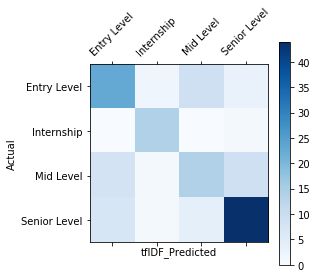

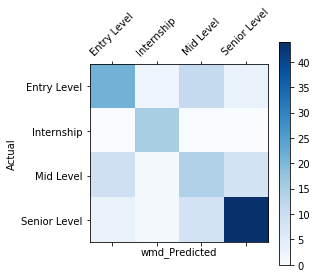

In [60]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_confusion_tfIDF)
plot_confusion_matrix(df_confusion_wmd)

In [76]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def print_evaluationMetrics(gt_data, pred_data):
    print("Accuracy %.4f" % accuracy_score(gt_data, pred_data))
    print("f1 score %.4f" % f1_score(gt_data, pred_data, average="weighted")) # average = "weighted" for class imbalance
    print("Precision %.4f" % precision_score(gt_data, pred_data, average="weighted"))
    print("Recall %.4f" % recall_score(gt_data, pred_data, average="weighted")) 

print "Scores for tfIDF based method:"
print_evaluationMetrics(gt_data, tfIDF_predicted_data)
print
print "Scores for Word Embeddings based method:"
print_evaluationMetrics(gt_data, wmd_predicted_data)

Scores for tfIDF based method:
Accuracy 0.6786
f1 score 0.6730
Precision 0.6706
Recall 0.6786

Scores for Word Embeddings based method:
Accuracy 0.6714
f1 score 0.6687
Precision 0.6697
Recall 0.6714
